In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from time_series_functions import *

In [3]:
df=pd.read_csv('../zillow_data.csv')

In [4]:
df=melt_data2(df)

In [5]:
df.set_index('time',inplace=True)

In [6]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

In [7]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [8]:
Arizona_df= df[(df['State'] == 'AZ')]

In [9]:
Arizona_df

,Zipcode,State,Metro,value
time,,,,
1996-04-01,85032,AZ,Phoenix,95400.0
1996-04-01,85710,AZ,Tucson,94600.0
1996-04-01,85225,AZ,Phoenix,101200.0
1996-04-01,85308,AZ,Phoenix,124800.0
1996-04-01,85281,AZ,Phoenix,81200.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [10]:
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [11]:
Arizona_recent_yrs

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85710,AZ,Tucson,171100.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [12]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]

In [13]:
Phoenix_data
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

In [14]:
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

In [17]:
zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==85258]

In [18]:
zip_zipcode.drop('Zipcode',axis=1,inplace=True)

zip_zipcode

,value
time,
2009-01-01,466800.0
2009-02-01,459400.0
2009-03-01,451300.0
2009-04-01,442400.0
2009-05-01,434000.0
...,...
2017-12-01,564700.0
2018-01-01,569100.0
2018-02-01,572400.0


In [19]:
resampled_shift_1 = zip_zipcode[['value']].shift(1)
resampled_shift_1.bfill(inplace=True)

In [20]:
zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
zip_zipcode['growth']= zip_zipcode['growth']

In [21]:
zip_zipcode.drop('value',axis=1,inplace=True)

In [22]:
stationarity_check(zip_zipcode)


Results of Dickey-Fuller Test: 

Test Statistic                  -2.296801
p-value                          0.173002
#Lags Used                       7.000000
Number of Observations Used    104.000000
Critical Value (1%)             -3.494850
Critical Value (5%)             -2.889758
Critical Value (10%)            -2.581822
dtype: float64


In [23]:
zip_zipcode=zip_zipcode[1:]

In [24]:
zip_zipcode=(np.log(zip_zipcode).diff())

In [25]:
cutoff = round(zip_zipcode.shape[0]*0.8)
cutoff

89

In [26]:
# Define train and test sets according to the index found above
train = zip_zipcode[:cutoff]

test = zip_zipcode[cutoff:]

In [27]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18] [19 20 21 22 23 24 25 26 27 28 29 30 31 32]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] [33 34 35 36 37 38 39 40 41 42 43 44 45 46]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46] [47 48 49 50 51 52 53 54 55 56 57 58 59 60]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60] [61 62 63 64 65 66 67 68 69 70 71 72 73 74]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74] [75 76 77 78 79 80 81 82 83 84 85 86 87 88]


In [28]:
baseline = train.shift(1)
baseline.dropna(inplace=True)

In [29]:
train.dropna(inplace=True)

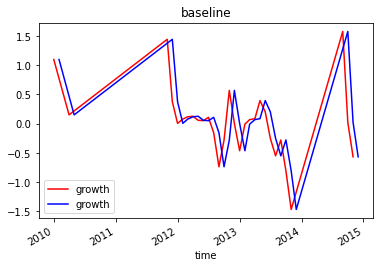

In [30]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [31]:
#np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

In [32]:
p_val = adfuller(train[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 0.0072235243255484635,
 so we can safely assume that the differenced data is stationary.


In [33]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

time
2010-01-01    0.000000
2010-04-01    1.098370
2011-11-01    0.613743
2011-12-01    0.813041
2012-01-01    0.897709
2012-02-01    0.186327
2012-03-01    0.043180
2012-04-01    0.099010
2012-05-01    0.122944
2012-06-01    0.092087
2012-07-01    0.054623
2012-08-01    0.080566
2012-09-01   -0.026455
2012-10-01   -0.453331
2012-11-01   -0.504616
2012-12-01    0.153735
2013-01-01    0.280148
2013-02-01   -0.235067
2013-03-01   -0.230513
2013-04-01    0.031369
2013-05-01    0.078040
2013-06-01    0.244501
2013-07-01    0.296710
2013-08-01   -0.029240
2013-09-01   -0.404054
2013-10-01   -0.411410
2013-11-01   -0.549630
2014-09-01   -1.146500
2014-10-01    0.090578
2014-11-01    0.782203
2015-05-01   -0.279425
2015-06-01    0.626916
2015-07-01    0.949337
2015-08-01   -0.013426
2015-09-01   -0.060050
2015-10-01   -0.010230
2015-11-01   -0.202817
2015-12-01   -0.342067
2016-01-01   -0.110854
2016-02-01   -0.252938
2016-03-01   -0.437229
2016-04-01    0.273094
Name: predicted_mean, dtype: 

In [34]:
sari_mod =SARIMAX(train,
                  order=(0, 1, 0),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [35]:
train_with_ind = train.reset_index()

In [36]:
for train_ind, val_ind in split.split(train_with_ind):
    sarimax = SARIMAX(endog=train_with_ind.iloc[train_ind, -1],
                      order=(1, 1, 1),
                     seasonal_order=(0, 1, 1, 52),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()
    preds = sarimax.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

0.37325770777258277
0.48303425296922237
1.0777774622932306
1.5686290171179302
0.4837211846144506


In [37]:
sari_mod = SARIMAX(zip_zipcode,
                  order=(1, 1, 1),
                  seasonal_order=(0, 1, 1, 52),
                  enforce_stationarity=False,
                  enforce_invertibility=False).fit()

In [45]:
forecast = sari_mod.forecast(steps=75)

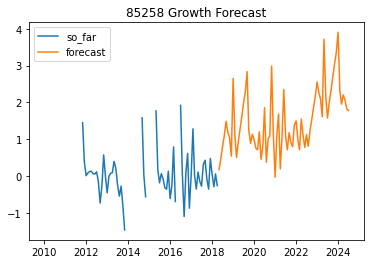

In [46]:
fig, ax = plt.subplots()
ax.plot(zip_zipcode, label='so_far')
ax.plot(forecast, label='forecast')
ax.set_title('85258 Growth Forecast')

plt.legend();

In [47]:
forecast.mean()

1.4896795880608877